# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

In [2]:
set_random_state(42)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [4]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3030


In [5]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['shape', 'hemo_aligned', 'gcamp_aligned', 'gcamp_interpolated', 'hemo_interpolated', 'correlation', 'width', 'height', 'start', 'stop', 'file_id', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_mean_centered', 'flow_components', 'mean_sources', 'mean_sinks', 'gcamp_mean'])

# Load data for features, select slow waves

In [6]:
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

#Filter waves and get all data for filtered indices (where)
where = corr < .3
where[height/width < 0.1] = False
where[left_too_high] = False
#where[height/width < 0.05] = False

print(np.sum(where))
    
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


205


In [7]:
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

Text(0, 0.5, 'Absolute frequency')

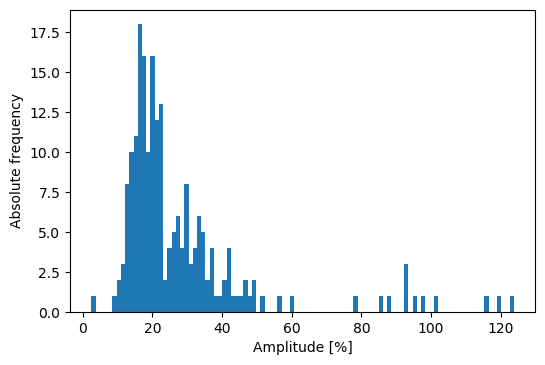

In [8]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

In [9]:
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)
relative_components = np.array([normalize(c) for c in components])
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

In [10]:
abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])

ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]

ratio_vertical_horizontal = ud/(ud+lr)

In [11]:
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

flow_by_tot = [leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot]

In [12]:
components[0]

array([0.0028429 , 0.00197521, 0.00017828, 0.00095401], dtype=float32)

In [13]:
import pandas as pd
crosscorr = np.corrcoef([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])
df = pd.DataFrame(crosscorr, columns = ["Left","right", "up", "down"])
df.insert(0, column = "", value = ["Left","right", "up", "down"])
df

,,Left,right,up,down
0,Left,1.000000,0.604078,-0.069588,-0.749162
1,right,0.604078,1.000000,-0.075030,-0.740856
2,up,-0.069588,-0.075030,1.000000,-0.485936
3,down,-0.749162,-0.740856,-0.485936,1.000000


In [14]:
components = (components.T / np.max(components, axis = 1)).T

In [15]:
#abs_up_flow - abs_down_flow

In [16]:
#for uf in [up_flow[iso == i] for i in list(set(isos))]:
#    plt.scatter(np.arange(len(uf)), uf)
#    plt.plot([0,60], [np.mean(uf), np.mean(uf)])

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [17]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.25

In [18]:
values = np.hstack([np.array([width]).T, np.array([height]).T])

In [19]:
sources_sinks_train, sources_sinks_test = train_test_split(sources_sinks, test_size=test_size, random_state = random_state)
vectors_train, vectors_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)
values_train, values_test = train_test_split(values, test_size=test_size, random_state = random_state)

values_train = normalize(values_train)

sources_sinks_train =  np.expand_dims(sources_sinks_train,-1)
sources_sinks_test =  np.expand_dims(sources_sinks_test,-1)
vectors_train = np.expand_dims(vectors_train,-1)
vectors_test = np.expand_dims(vectors_test, -1)

vectors_train = np.expand_dims(vectors_train,1)
vectors_test = np.expand_dims(vectors_test, -1)

Save additional features as variables.

In [20]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]
additional_features = [train_test_split(f, test_size=test_size, random_state = random_state) for f in additional_features]
add_train = [f[0] for f in additional_features]
add_test = [f[1] for f in additional_features]
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_test, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

In [21]:
print("There are " + str(len(iso_test)) + " test samples")

There are 52 test samples


In [22]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [23]:
## network parameters
from predictive_modeling.models.vae_cnn_v1 import *
from keras import Model

batch_size = 100
epochs = 200

n_values = 2

In [24]:
[image_input, value_input, vector_input], [z_mean, z_log_var, z] = encoder(n_values)
latent_inputs, [image_decoded, values_decoded, vector_decoded] = decoder(n_values)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


../../predictive_modeling/models/vae_cnn_v1.py:111: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v1.py:112: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v1.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


(None, 1, 128, 1)


In [25]:
encoder_model = Model(inputs = [image_input, value_input, vector_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded, vector_decoded], name='decoder')

In [26]:
image_decoded, values_decoded, vector_decoded = decoder_model(encoder_model([image_input, value_input, vector_input])[2])

In [27]:
vae = Model(inputs = [image_input, value_input, vector_input], 
            outputs = [image_decoded, values_decoded, vector_decoded], name='vae_mlp')

In [28]:
print("The input shapes of the autoencoder are: ")
print(image_input.shape)
print(value_input.shape)
print(vector_input.shape)

The input shapes of the autoencoder are: 
(None, 64, 128, 1)
(None, 2)
(None, 1, 128, 1)


In [29]:
import keras
loss, loss_width_height, loss_signal_in_time, img_reconstruction_loss = get_vae_loss(image_input, value_input, vector_input, image_decoded, values_decoded, vector_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100)
vae.add_loss(loss)
vae.add_metric(loss_width_height, name='loss_width_height')
#vae.add_metric(loss_direction, name='loss_direction')
vae.add_metric(loss_signal_in_time, name='loss_signal_in_time')
vae.add_metric(img_reconstruction_loss, name='img_reconstruction_loss')

#vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [30]:
x_train_combined = [sources_sinks_train, values_train, vectors_train]

In [45]:
# train the autoencoder
history = vae.fit(x_train_combined, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/250
 - 1s - loss: 22.6906 - loss_width_height: 7.2475e-04 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0203
Epoch 2/250
 - 2s - loss: 22.2765 - loss_width_height: 6.4087e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0202
Epoch 3/250
 - 1s - loss: 22.5730 - loss_width_height: 7.1560e-04 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0199
Epoch 4/250
 - 2s - loss: 22.3867 - loss_width_height: 6.9470e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0198
Epoch 5/250
 - 2s - loss: 22.4258 - loss_width_height: 8.1217e-04 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0192
Epoch 6/250
 - 1s - loss: 22.5340 - loss_width_height: 8.5509e-04 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0205
Epoch 7/250
 - 1s - loss: 22.5310 - loss_width_height: 6.7592e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0199
Epoch 8/250
 - 1s - loss: 22.6574 - loss_width_height: 7.6563e-04 - loss_signal_in_time: 0

Epoch 64/250
 - 1s - loss: 22.3101 - loss_width_height: 7.2086e-04 - loss_signal_in_time: 0.0071 - img_reconstruction_loss: 0.0200
Epoch 65/250
 - 1s - loss: 22.0172 - loss_width_height: 7.3258e-04 - loss_signal_in_time: 0.0071 - img_reconstruction_loss: 0.0196
Epoch 66/250
 - 1s - loss: 22.0456 - loss_width_height: 8.0148e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0190
Epoch 67/250
 - 1s - loss: 22.0043 - loss_width_height: 6.4457e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0198
Epoch 68/250
 - 1s - loss: 22.0171 - loss_width_height: 7.1703e-04 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0199
Epoch 69/250
 - 1s - loss: 22.0949 - loss_width_height: 7.8530e-04 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0190
Epoch 70/250
 - 1s - loss: 22.0141 - loss_width_height: 8.5946e-04 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0204
Epoch 71/250
 - 1s - loss: 22.2016 - loss_width_height: 7.7012e-04 - loss_signal_in

Epoch 127/250
 - 1s - loss: 21.8440 - loss_width_height: 8.7113e-04 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0198
Epoch 128/250
 - 1s - loss: 21.9311 - loss_width_height: 8.6291e-04 - loss_signal_in_time: 0.0071 - img_reconstruction_loss: 0.0206
Epoch 129/250
 - 1s - loss: 21.7729 - loss_width_height: 7.5088e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0191
Epoch 130/250
 - 1s - loss: 21.5963 - loss_width_height: 7.3365e-04 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0196
Epoch 131/250
 - 1s - loss: 21.7044 - loss_width_height: 7.2737e-04 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0191
Epoch 132/250
 - 1s - loss: 21.8847 - loss_width_height: 7.5639e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0189
Epoch 133/250
 - 1s - loss: 21.7434 - loss_width_height: 7.2297e-04 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0200
Epoch 134/250
 - 1s - loss: 21.8537 - loss_width_height: 7.4181e-04 - loss_s

 - 1s - loss: 21.0920 - loss_width_height: 7.0613e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0192
Epoch 190/250
 - 1s - loss: 21.6923 - loss_width_height: 6.3571e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0198
Epoch 191/250
 - 1s - loss: 21.7643 - loss_width_height: 7.5006e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0194
Epoch 192/250
 - 1s - loss: 21.6416 - loss_width_height: 7.6758e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0193
Epoch 193/250
 - 1s - loss: 22.1776 - loss_width_height: 8.4652e-04 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0197
Epoch 194/250
 - 1s - loss: 21.6184 - loss_width_height: 8.4696e-04 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0194
Epoch 195/250
 - 1s - loss: 21.6801 - loss_width_height: 8.4071e-04 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0182
Epoch 196/250
 - 1s - loss: 21.7331 - loss_width_height: 8.7488e-04 - loss_signal_in_time:

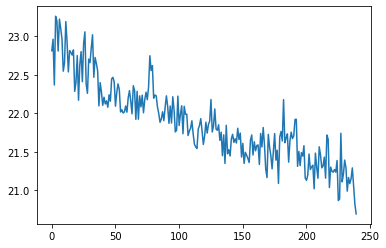

In [46]:
plt.plot(vae.history.history["loss"][10:])

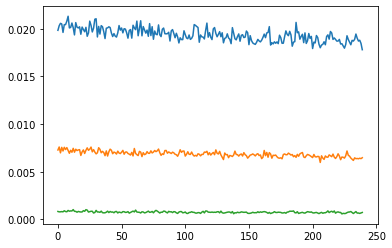

In [47]:
plt.plot(vae.history.history["img_reconstruction_loss"][10:])
plt.plot(vae.history.history["loss_signal_in_time"][10:])
plt.plot(vae.history.history["loss_width_height"][10:])
#plt.plot(vae.history.history["val_loss_direction"][10:])

# Visualize predictions

In [48]:
res = vae.predict(x_train_combined)

In [49]:
val_predictions = res[1]

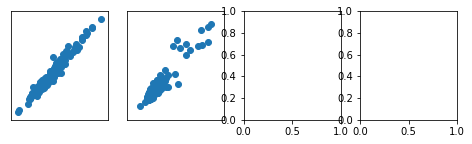

In [50]:
fig, ax = plt.subplots(1,4, figsize = (8,2))
for x in range(2):
    ax[x].scatter(val_predictions[:,0+x], values_train[:,0+x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])

In [51]:
from scipy.ndimage import median_filter

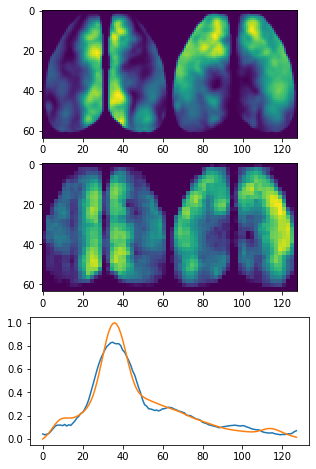

In [52]:
i = 3
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i][:,:,0])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[2][i][0,:128,0])
ax[2].plot(vectors_train[i][0,:128,0])

In [53]:
from plots import manifold
from plots import manifold_of_images

In [85]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder_model.predict(x_train_combined)[2].T

In [149]:
%%capture
x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
x_range = [x_min, x_max]
y_range = [y_min, y_max]

man_mean_signal = manifold(decoder_model, x_range, y_range, n = 15, dpi = 300, scale="sqrt", multi_output = True)

In [153]:
import random
def manifold_of_vector_components(figsize=(5,5), dpi = 200, n = 15, decoder_model = None, x_range = [0,1], y_range = [0, 1], cmap = "inferno", debug = False):
    udlr = np.ndarray(shape = (n,n), dtype = np.ndarray)
    if decoder_model:
        for y_pos, y in enumerate(np.linspace(y_range[0], y_range[1], n)):
            for x_pos, x in enumerate(np.linspace(x_range[0], x_range[1], n)):
                udlr[y_pos,x_pos] = np.array(decoder_model.predict([[[y,x]]])[1][0][130:134])
        
    fig, ax = plt.subplots(n, n, figsize= figsize, dpi = dpi)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)

    for y in range(n):
        for x in range(n):
            if debug:
                ax[y,x].imshow(render_arrow_components(random.uniform(0,1) ,random.uniform(0,1), random.uniform(0,1) ,random.uniform(0,1) ))
            else:
                ax[y,x].imshow(render_arrow_components(udlr[y,x][0], udlr[y,x][1], udlr[y,x][2], udlr[y,x][3], cmap = cmap))
                ax[y,x].set_facecolor('black')

            ax[y,x].axis("off")
    return fig2rgb_array(fig)

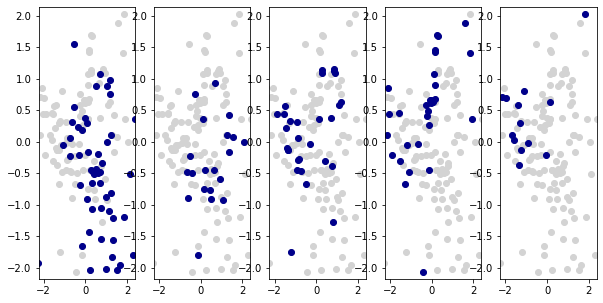

In [154]:
z_train = encoder_model.predict(x_train_combined)[2].T

fig, ax = plt.subplots(1,5, figsize= (10,5))
isos = [1.8, 2.0, 2.2, 2.4, 2.6]

def add_feature_plot(ax, iso):
    ax.scatter(*z_train, c= "lightgray")
    ax.scatter(*(z_train.T[iso_train == iso]).T, c = "darkblue")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

for iso, a in zip(isos,ax):
    add_feature_plot(a, iso)

In [161]:
%%capture
manifold_vector_components = manifold_of_vector_components(x_range = x_range, y_range = y_range, decoder_model = decoder_model, debug = True)

In [158]:
sources_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sources")
sinks_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sinks")

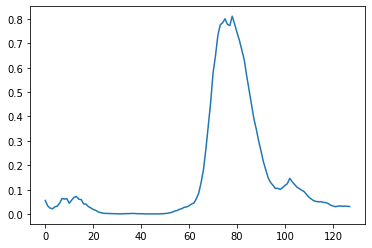

In [159]:
plt.plot(decoder_model.predict([[[2,2]]])[2][0,0,:,0])

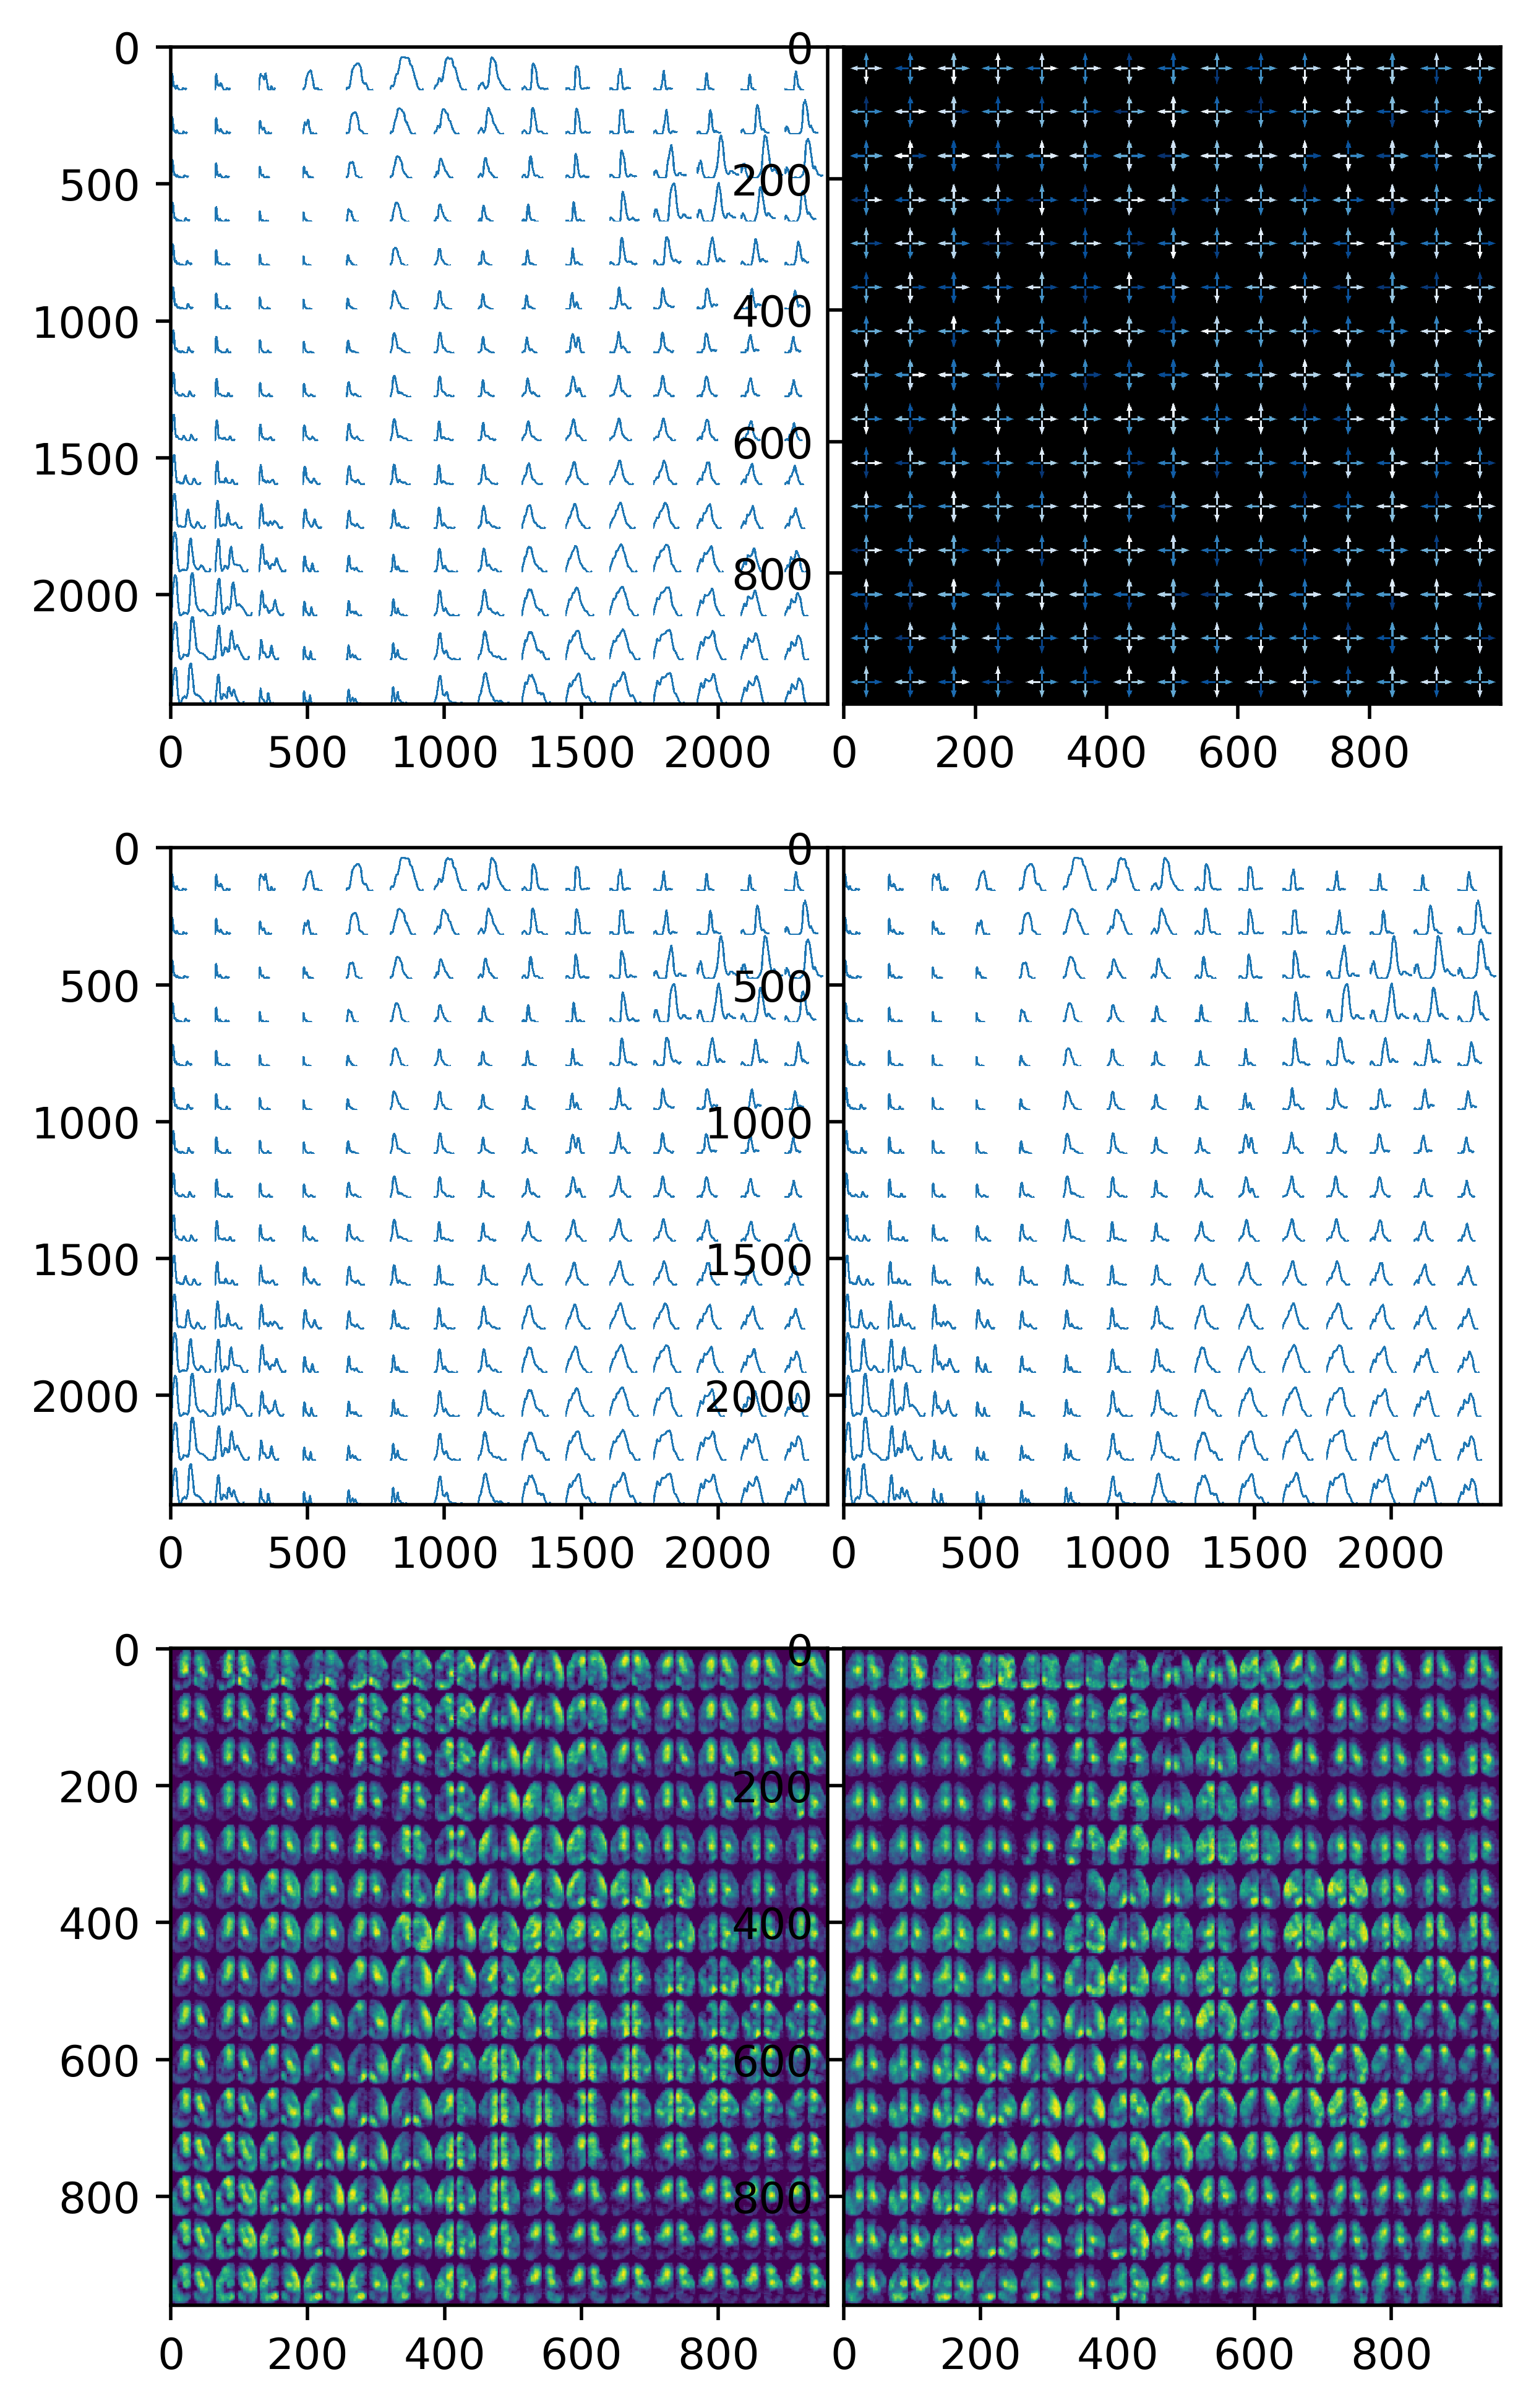

In [160]:
fig = plt.figure(constrained_layout = False, figsize = (10, 10), dpi = 500)
gs1 = fig.add_gridspec(nrows = 6, ncols = 4, left=0.05, right=0.48, wspace=0.05)
ax0 = fig.add_subplot(gs1[0:2, 0:2])
ax1 = fig.add_subplot(gs1[0:2, 2:4])
ax2 = fig.add_subplot(gs1[2:4, 0:2])
ax3 = fig.add_subplot(gs1[2:4, 2:4])
ax4 = fig.add_subplot(gs1[4:6, 0:2])
ax5 = fig.add_subplot(gs1[4:6, 2:4])

ax0.imshow(man_mean_signal)
ax1.imshow(manifold_vector_components)
ax2.imshow(man_mean_signal)
ax3.imshow(man_mean_signal)
ax4.imshow(sources_manifold)
ax5.imshow(sinks_manifold)

In [65]:
x_train.shape

(153, 130)

# Visualization

In [36]:
vae.save("full_vae")

In [41]:
vae = keras.models.load_model("full_vae", custom_objects={'tf': tf}, compile = False)